<a href="https://colab.research.google.com/github/sorayutmild/ENE461_sorayut/blob/main/ENE461_homework4_week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Image Filtering
Description
Write a program for spatial filtering.

1) Low pass filter

2) High pass filter



### นายสรยุทธ มียิ้ม ENE 61070502468

## Table of contents:
* [Load and Read the images](#1)
* [ข้อที่ 1 Low pass filter](#2)
* [ข้อที่ 2 High pass filter](#3)
* [Discussion](#4)

## Load and Read the images <a name='1'></a>

In [1]:
import numpy as np # for work with multi-dimensional array
import matplotlib.pyplot as plt # for Read and write images
import glob # for weorking with files
import os # for weorking with files
import cv2 # for work with image.
import seaborn as sns # for visualization
import scipy.stats as st

In [2]:
# create ./test_images path for store the test images.
test_path = './test_images'
if not os.path.exists(test_path):
    os.mkdir(test_path)

In [3]:
import urllib.request

all_image_url = ['https://images.freeimages.com/images/large-previews/b90/amy-lee-1432188.jpg',
                 'https://images.freeimages.com/images/large-previews/39e/city-at-night-1233545.jpg']
all_save_name = ['image_1.jpg', 'image_2.jpg'] #local name to be saved

def download_image(all_image_url, all_save_name):
    for idx in range(len(all_image_url)):
        urllib.request.urlretrieve(all_image_url[idx], os.path.join(test_path, all_save_name[idx]))

download_image(all_image_url, all_save_name)

In [4]:
class show_images:
    def __init__(self, images_folder_path, ):
        self.images_folder_path = images_folder_path
        self.images_and_names = self.read_all_images()
        self.names = self.read_all_images()['names']

    def read_all_images(self):
        images = []
        names = []
        for img_path in glob.glob(self.images_folder_path+'/*'):
            img = plt.imread(img_path)
            images.append(img)
            names.append(img_path.split('/')[-1])
        images_and_names = {'images':images, 'names':names}
        return images_and_names
    
    def show_images(self, images):
        for idx, img in enumerate(images):
            plt.title(self.names[idx])
            plt.axis('off')
            plt.imshow(img, cmap='gray')
            plt.show()
    
    def show_subplot_images(self, images,  nrows=2, ncols=4, figsize=(20,10)):
        plt.figure(figsize=figsize)
        for idx, img in enumerate(images):
            plt.subplot(nrows, ncols, idx+1)
            plt.title(self.names[idx])
            plt.axis('off')
            plt.imshow(img, cmap='gray')
        plt.show()
    
    def show_compare_images(self, images1, images2, title1='', title2='', nrows=8,figsize=(10,40)):
        for row, idx in enumerate(range(0, nrows*2, 2)):
            plt.figure(figsize=figsize)
            plt.subplot(nrows, 2, idx+1)
            plt.axis('off')
            plt.title(title1)
            plt.imshow(images1[row], cmap='gray')

            plt.subplot(nrows, 2, idx+2)
            plt.axis('off')
            plt.title(title2)
            plt.imshow(images2[row], cmap='gray')
            plt.show()

    def show_images_and_hist(self, images, thresholds=[], bins=100, figsize=(20,20)):
        gray_images = self.rgb_to_gray(images)
        for row, idx in enumerate(range(0, len(images)*2, 2)):
            plt.figure(figsize=figsize)
            plt.subplot(len(images), 2, idx+1)
            plt.axis('off')
            plt.imshow(images[row], cmap='gray')

            plt.subplot(len(images), 2, idx+2)
            # plt.axis('off')
            plt.title(self.names[row])
            plt.xlabel('Intensity')
            plt.ylabel('Number of Pixel')
            plt.hist(gray_images[row].flatten(), bins)
            if len(thresholds) == len(images):
                plt.axvline(thresholds[row], 0, 1, label='pyplot vertical line', color='r')
            plt.show()

    def rgb_to_gray(self, images):
        return [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]


    def gray_to_binary(self, gray_images, thresholds):
        binary_images = []
        for idx, gi in enumerate(gray_images):
            binary_image = np.where(gi < thresholds[idx], 0, 1)
            binary_images.append(binary_image)
        return binary_images

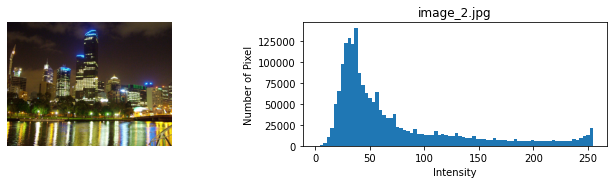

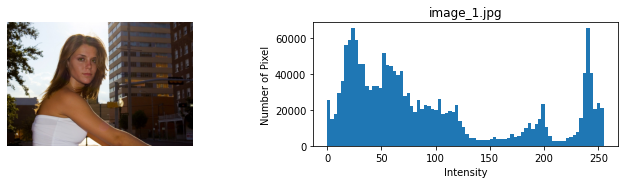

In [5]:
my_cv = show_images(test_path) # input is path where the images is belong.
# show all the images.
images = my_cv.images_and_names['images']
my_cv.show_images_and_hist(images, figsize=(12,5), bins=80)

In [6]:
gray_images = my_cv.rgb_to_gray(images)

## ข้อที่ 1 Low pass filter <a name='2'></a>

In [7]:
def conv(image, mask, padding=False, stride=1):
    h_mask = mask.shape[0]
    w_mask = mask.shape[1]
    h_image = image.shape[0]
    w_image = image.shape[1]

    if padding==True:
        h_pad_size = (h_image - 1)*stride + h_mask - h_image
        w_pad_size = (w_image - 1)*stride + w_mask - w_image
        output_image = np.zeros((h_image+h_pad_size, w_image+w_pad_size))
    else:
        output_image = np.zeros((h_image, w_image))

    for y in range(0, output_image.shape[0], stride):
        # print(y)
        for x in range(0, output_image.shape[1], stride):
            sub_img = image[y:y+h_mask, x:x+w_mask]
            # out of row
            if sub_img.shape[1] < w_mask:
                break
            # out of col
            if sub_img.shape[0] < h_mask:
                break
            output_image[y][x] = np.sum(image[y:y+h_mask, x:x+w_mask]*mask)

    return output_image[0:h_image, 0:w_image]

In [8]:
def create_gaussian_mask(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [15]:
gaussian_mask = create_gaussian_mask(50)
average_mask = np.ones((50,50)) / 50

In [16]:
average_low_pass_images = [conv(g_img, average_mask) for g_img in gray_images]
gaussian_low_pass_images = [conv(g_img, gaussian_mask) for g_img in gray_images]

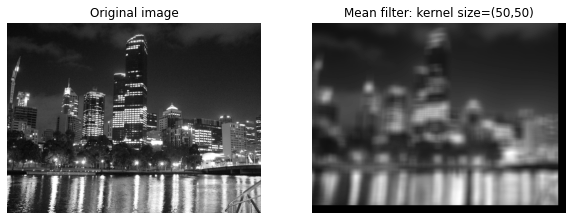

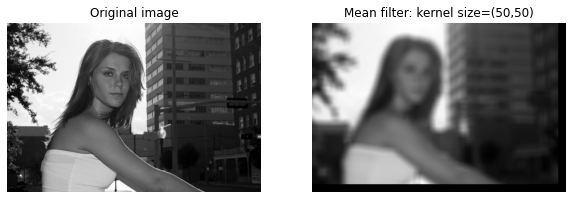

In [17]:
my_cv.show_compare_images(gray_images, average_low_pass_images, title1='Original image', title2='Mean filter: kernel size=(50,50)', nrows=len(gray_images))

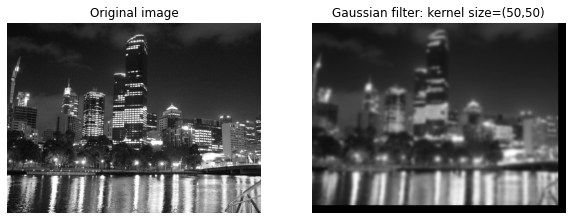

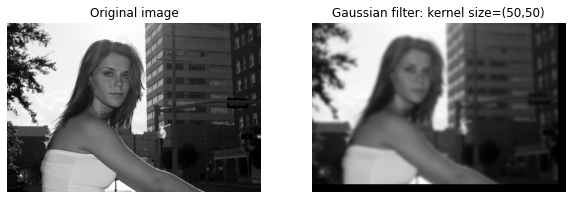

In [18]:
my_cv.show_compare_images(gray_images, gaussian_low_pass_images, title1='Original image', title2='Gaussian filter: kernel size=(50,50)', nrows=len(gray_images))

## ข้อที่ 2 High pass filter <a name='3'></a>

In [20]:
log_mask = np.array([[0, 0, 1, 0, 0], [0, 1, 2, 1, 0], [1, 2, -16, 2, 1], [0, 1, 2, 1, 0], [0, 0, 1, 0, 0]])
log_mask

array([[  0,   0,   1,   0,   0],
       [  0,   1,   2,   1,   0],
       [  1,   2, -16,   2,   1],
       [  0,   1,   2,   1,   0],
       [  0,   0,   1,   0,   0]])

In [21]:
log_high_pass_images = [conv(g_img, log_mask) for g_img in gray_images]

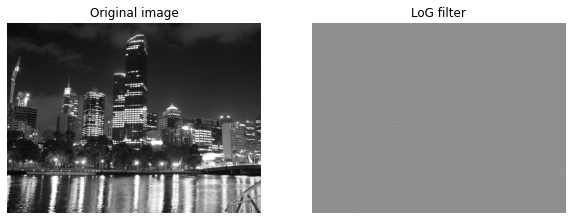

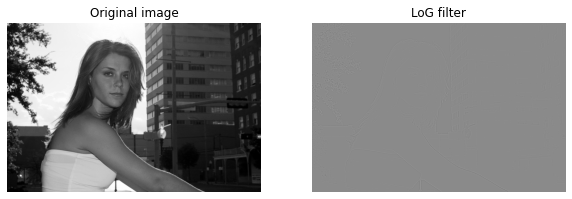

In [22]:
my_cv.show_compare_images(gray_images, log_high_pass_images, title1='Original image', title2='LoG filter', nrows=len(gray_images))

## Discussion <a name='4'></a>

พบว่าในการใช้ทำการ low-pass filter ทั้งแบบ mean filter และ gaussian filter ในขนาด mask ที่เท่ากัน พบว่าแบบ mean filter จะสูญเสีย information มากกว่า แบบ gaussian filter เนื่องจากว่า mean filter เป็นการเฉลี่ยแบบ uniform ต่างกับ gaussian ที่เป็นการเฉลี่ยแบบถ่วงน้ำหนัก

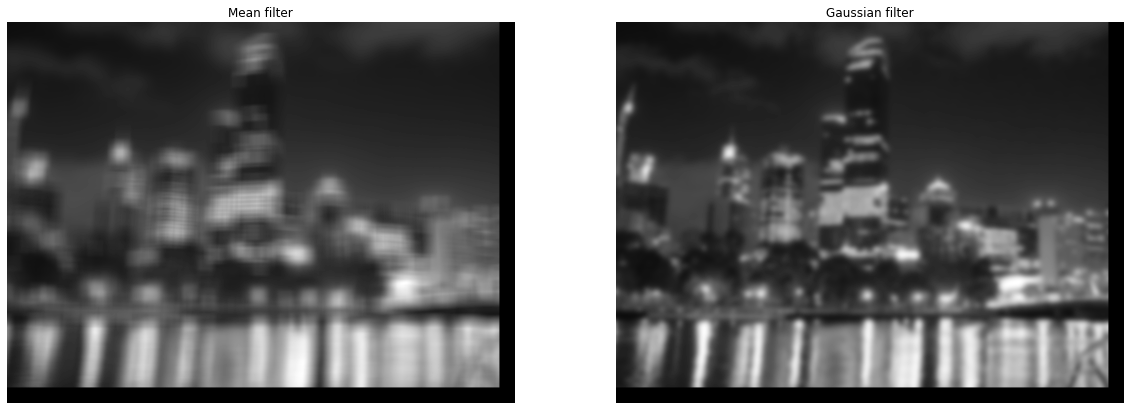

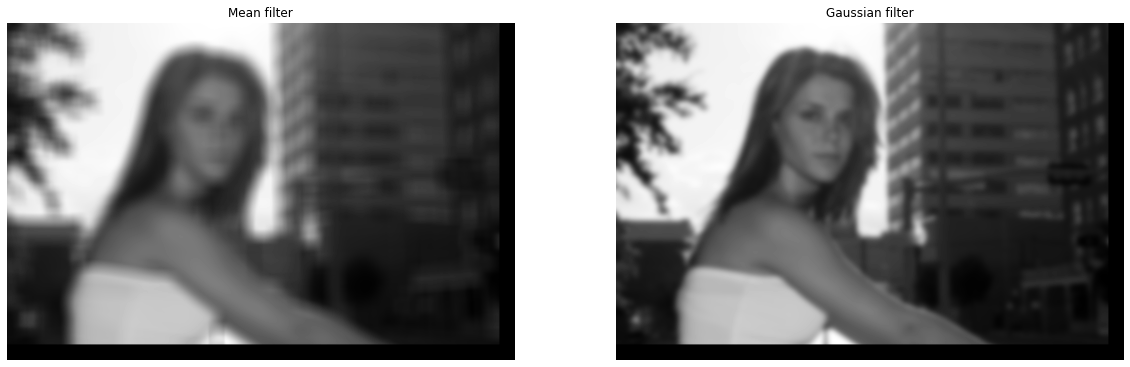

In [23]:
my_cv.show_compare_images(average_low_pass_images, gaussian_low_pass_images, title1='Mean filter', title2='Gaussian filter', nrows=len(images), figsize=(20,40))

ในการทำ high-pass filter โดยใช้ Laplacian of Gaussian filter จะได้ค่าที่มี noise น้อย เนื่องจากได้ทำการ low-pass filter เพื่อลด noise ก่อนการทำ high-pass filter

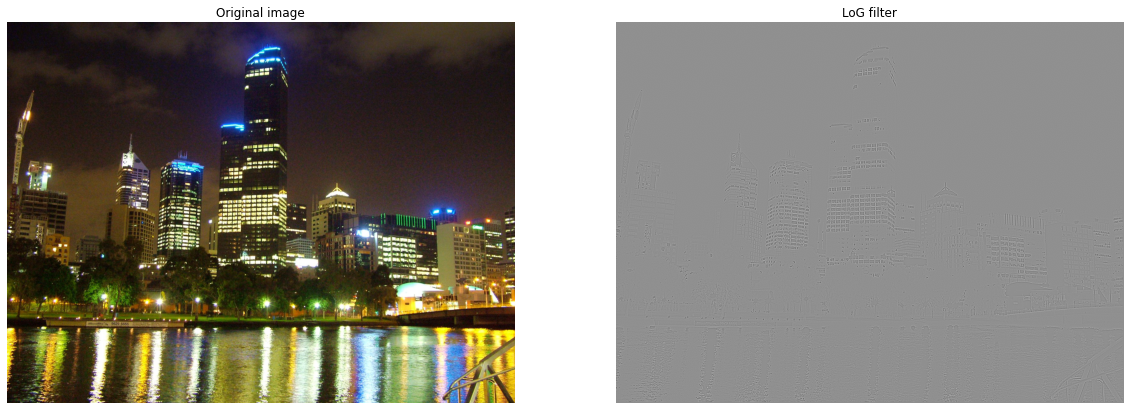

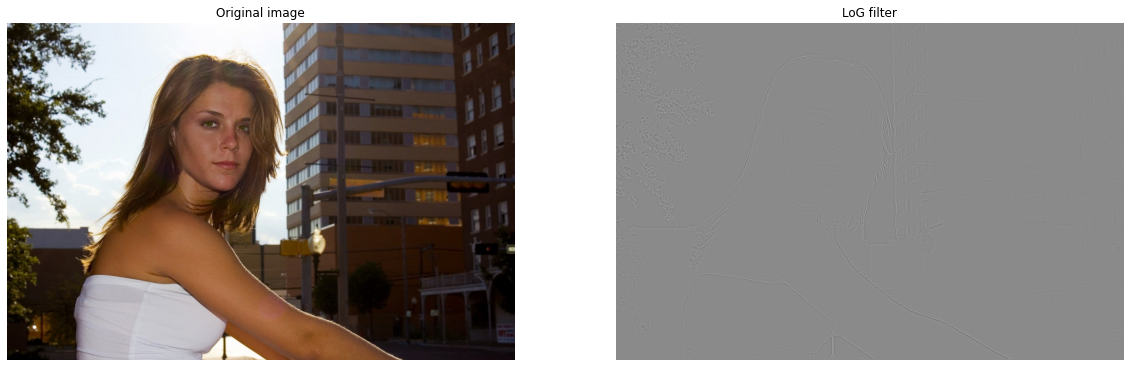

In [24]:
my_cv.show_compare_images(images, log_high_pass_images, title1='Original image', title2='LoG filter', nrows=len(images), figsize=(20,40))